In [3]:
import pennylane as qml
import numpy as np
import jax
import matplotlib.pyplot as plt
from io import StringIO
import sys
from typing import List, Protocol, Callable, Tuple
from typing import List, Tuple, Callable


# Configure JAX
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jnp = jax.numpy

def create_transverse_hamiltonian(num_wires: int, J: float = 1.0, h: float = 0.5):
    coeffs = []
    obs = []

    # ZZ interactions
    for i in range(num_wires):
        for j in range(i + 1, num_wires):
            coeffs.append(-J)
            obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # X interactions
    for i in range(num_wires):
        coeffs.append(-h)
        obs.append(qml.PauliX(i))

    hamiltonian = qml.Hamiltonian(coeffs, obs)
    e_min = min(qml.eigvals(hamiltonian))
    e_max = max(qml.eigvals(hamiltonian))
    # hamiltonian = qml.SparseHamiltonian(hamiltonian.sparse_matrix(), range(num_wires))
    return hamiltonian, e_min, e_max

def create_heisenberg_hamiltonian(num_wires: int, J: float = 1.0):
    coeffs = []
    obs = []

    # Heisenberg interactions (XX + YY + ZZ)
    for i in range(num_wires):
        for j in range(i + 1, num_wires):
            coeffs.extend([-J, -J, -J])
            obs.extend([qml.PauliX(i) @ qml.PauliX(j), qml.PauliY(i) @ qml.PauliY(j), qml.PauliZ(i) @ qml.PauliZ(j)])

    hamiltonian = qml.Hamiltonian(coeffs, obs)
    e_min = min(qml.eigvals(hamiltonian))
    e_max = max(qml.eigvals(hamiltonian))
    # hamiltonian = qml.SparseHamiltonian(hamiltonian.sparse_matrix(), range(num_wires))
    return hamiltonian, e_min, e_max

def create_longitudinal_ising_hamiltonian(num_wires: int, J: float = 1.0, hx: float = 0.5, hz: float = 0.5):
    coeffs = []
    obs = []

    # ZZ interactions
    for i in range(num_wires):
        for j in range(i + 1, num_wires):
            coeffs.append(-J)
            obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # X interactions (transverse field)
    for i in range(num_wires):
        coeffs.append(-hx)
        obs.append(qml.PauliX(i))
    
    # Z interactions (longitudinal field)
    for i in range(num_wires):
        coeffs.append(-hz)
        obs.append(qml.PauliZ(i))

    hamiltonian = qml.Hamiltonian(coeffs, obs)
    e_min = min(qml.eigvals(hamiltonian))
    e_max = max(qml.eigvals(hamiltonian))
    # hamiltonian = qml.SparseHamiltonian(hamiltonian.sparse_matrix(), range(num_wires))

    return hamiltonian, e_min, e_max

In [4]:

class Operation(Protocol):
    def apply(self, params: np.ndarray, wires: List[int]) -> None:
        ...

class TwoQubitDecomp:
    def apply(self, params: np.ndarray, wires: List[int]) -> None:
        """Implement an arbitrary SU(4) gate on two qubits
        using the decomposition from Theorem 5 in
        https://arxiv.org/pdf/quant-ph/0308006.pdf"""
        i, j = wires
        qml.Rot(*params[:3], wires=i)
        qml.Rot(*params[3:6], wires=j)
        qml.CNOT(wires=[j, i])
        qml.RZ(params[6], wires=i)
        qml.RY(params[7], wires=j)
        qml.CNOT(wires=[i, j])
        qml.RY(params[8], wires=j)
        qml.CNOT(wires=[j, i])
        qml.Rot(*params[9:12], wires=i)
        qml.Rot(*params[12:15], wires=j)

class PauliRotSequence:
    def apply(self, params: np.ndarray, wires: List[int]) -> None:
        qml.ArbitraryUnitary(params, wires=wires)

class SpecialUnitaryGate:
    def apply(self, params: np.ndarray, wires: List[int]) -> None:
        qml.SpecialUnitary(params, wires=wires)

# Initialize parameters
num_wires = 6
loc = 2
learning_rate = 1e-4
num_steps = 1000
rebuild = False
# init_params = jax.numpy.array(init_params)
# # Define a function that returns a default value for the innermost dictionary
# def nested_dict():
#     return defaultdict(lambda: defaultdict(lambda: [None, None]))

# Initialize the top-level defaultdict
energies = {}

dev = qml.device("default.qubit", wires=num_wires)

def circuit(params, operation: Operation, hamiltonian):
        for params_block in params:
            for i, params_layer in enumerate(params_block):
                for j, params_op in enumerate(params_layer):
                    wires_op = [w % num_wires for w in range(loc * j + i, loc * (j + 1) + i)]
                    operation.apply(params_op, wires_op)
        return qml.expval(hamiltonian)


#  circuitLauncher
def launch_circuit(hamiltonian_func: Callable[[], Tuple[qml.Hamiltonian, float]]):
    hamiltonian, e_min, e_max = hamiltonian_func()
    def circuit_wrapped(params, operation: Operation):
        return circuit(params, operation, hamiltonian)

    qnode = qml.QNode(circuit_wrapped, dev, interface="jax")
    return qnode, e_min, e_max

# run the loop
import pickle
import os

def save_data(hamiltonian_name, operation_name, num_blocks, energy, final_energy, E_min, E_max):
    directory = f'data/energies/{hamiltonian_name}/{operation_name}'
    os.makedirs(directory, exist_ok=True)
    file_path = f'{directory}/{num_blocks}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump([energy, abs(final_energy), E_min, E_max], f)

def load_data(hamiltonian_name, operation_name, num_blocks):
    file_path = f'data/energies/{hamiltonian_name}/{operation_name}/{num_blocks}.pkl'
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    return None

init_params = {}
def run(operations: List[Tuple[str, Operation]], hamiltonian_funcs: List[Tuple[str, Callable[[], Tuple[qml.Hamiltonian, float]]]]):
    energies = {}

    for hamiltonian_name, hamiltonian_func in hamiltonian_funcs:
        energies[hamiltonian_name] = {}
        init_params[hamiltonian_name] = {}
        for operation_name, operation in operations:
            energies[hamiltonian_name][operation_name] = {}
            qnode, E_min, E_max = launch_circuit(hamiltonian_func)
            for num_blocks in range(2, 11, 2):
                # Load data if it exists
                if num_blocks not in init_params[hamiltonian_name]:
                    init_params[hamiltonian_name][num_blocks] = np.random.normal(0, 0.01, size=[num_blocks, 2, num_wires//2, 15])
                data = None
                energy = []
                print(f"Running the optimization for the {operation_name} with {hamiltonian_name} repeats {num_blocks}, E_min {E_min}, E_max {E_max}")
                if rebuild == False:
                    data = load_data(hamiltonian_name, operation_name, num_blocks)
                if data is not None:
                    energies[hamiltonian_name][operation_name][num_blocks] = data
                    continue
                params = init_params[hamiltonian_name][num_blocks].copy()
                for step in range(1, num_steps + 1):
                    cost = qnode(params, operation) #
                    grad_func = jax.jacobian(qnode)
                    params = params - learning_rate * grad_func(params, operation)
                    energy.append(cost)
                if step % 50 == 0:
                    print(f"{step} Steps: {cost:.6f}")
                final_energy = energy[-1]
                energies[hamiltonian_name][operation_name][num_blocks] = [energy, abs(final_energy), E_min, E_max]
                
                # Save data to file
                save_data(hamiltonian_name, operation_name, num_blocks, energy, final_energy, E_min, E_max)
                
    return energies
    
if __name__ == "__main__":
    # Example of running the optimization
    hamiltonian_funcs = [("ZZ Hamiltonian", lambda: create_transverse_hamiltonian(num_wires)), 
                         ("Heisenberg Hamiltonian", lambda: create_heisenberg_hamiltonian(num_wires)),
                         ("Longitudinal Ising Hamiltonian", lambda: create_longitudinal_ising_hamiltonian(num_wires))]

    
    operations = [("TwoQubitDecomp", TwoQubitDecomp()), 
                  ("PauliRotSequence", PauliRotSequence()), 
                  ("SpecialUnitaryGate", SpecialUnitaryGate())]

    energies = run(operations, hamiltonian_funcs)


/opt/homebrew/anaconda3/envs/pennylane/lib/python3.12/site-packages/pennylane/ops/functions/eigvals.py:120: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


Running the optimization for the TwoQubitDecomp with ZZ Hamiltonian repeats 2, E_min -15.150118797798026, E_max 4.729066465332297
50 Steps: -15.025628
100 Steps: -15.065653
150 Steps: -15.092683
200 Steps: -15.110951
250 Steps: -15.123312
300 Steps: -15.131689
350 Steps: -15.137377
400 Steps: -15.141248
450 Steps: -15.143889
500 Steps: -15.145698


KeyboardInterrupt: 

/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_8329/421371945.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(operations))  # Unique colors for each operation


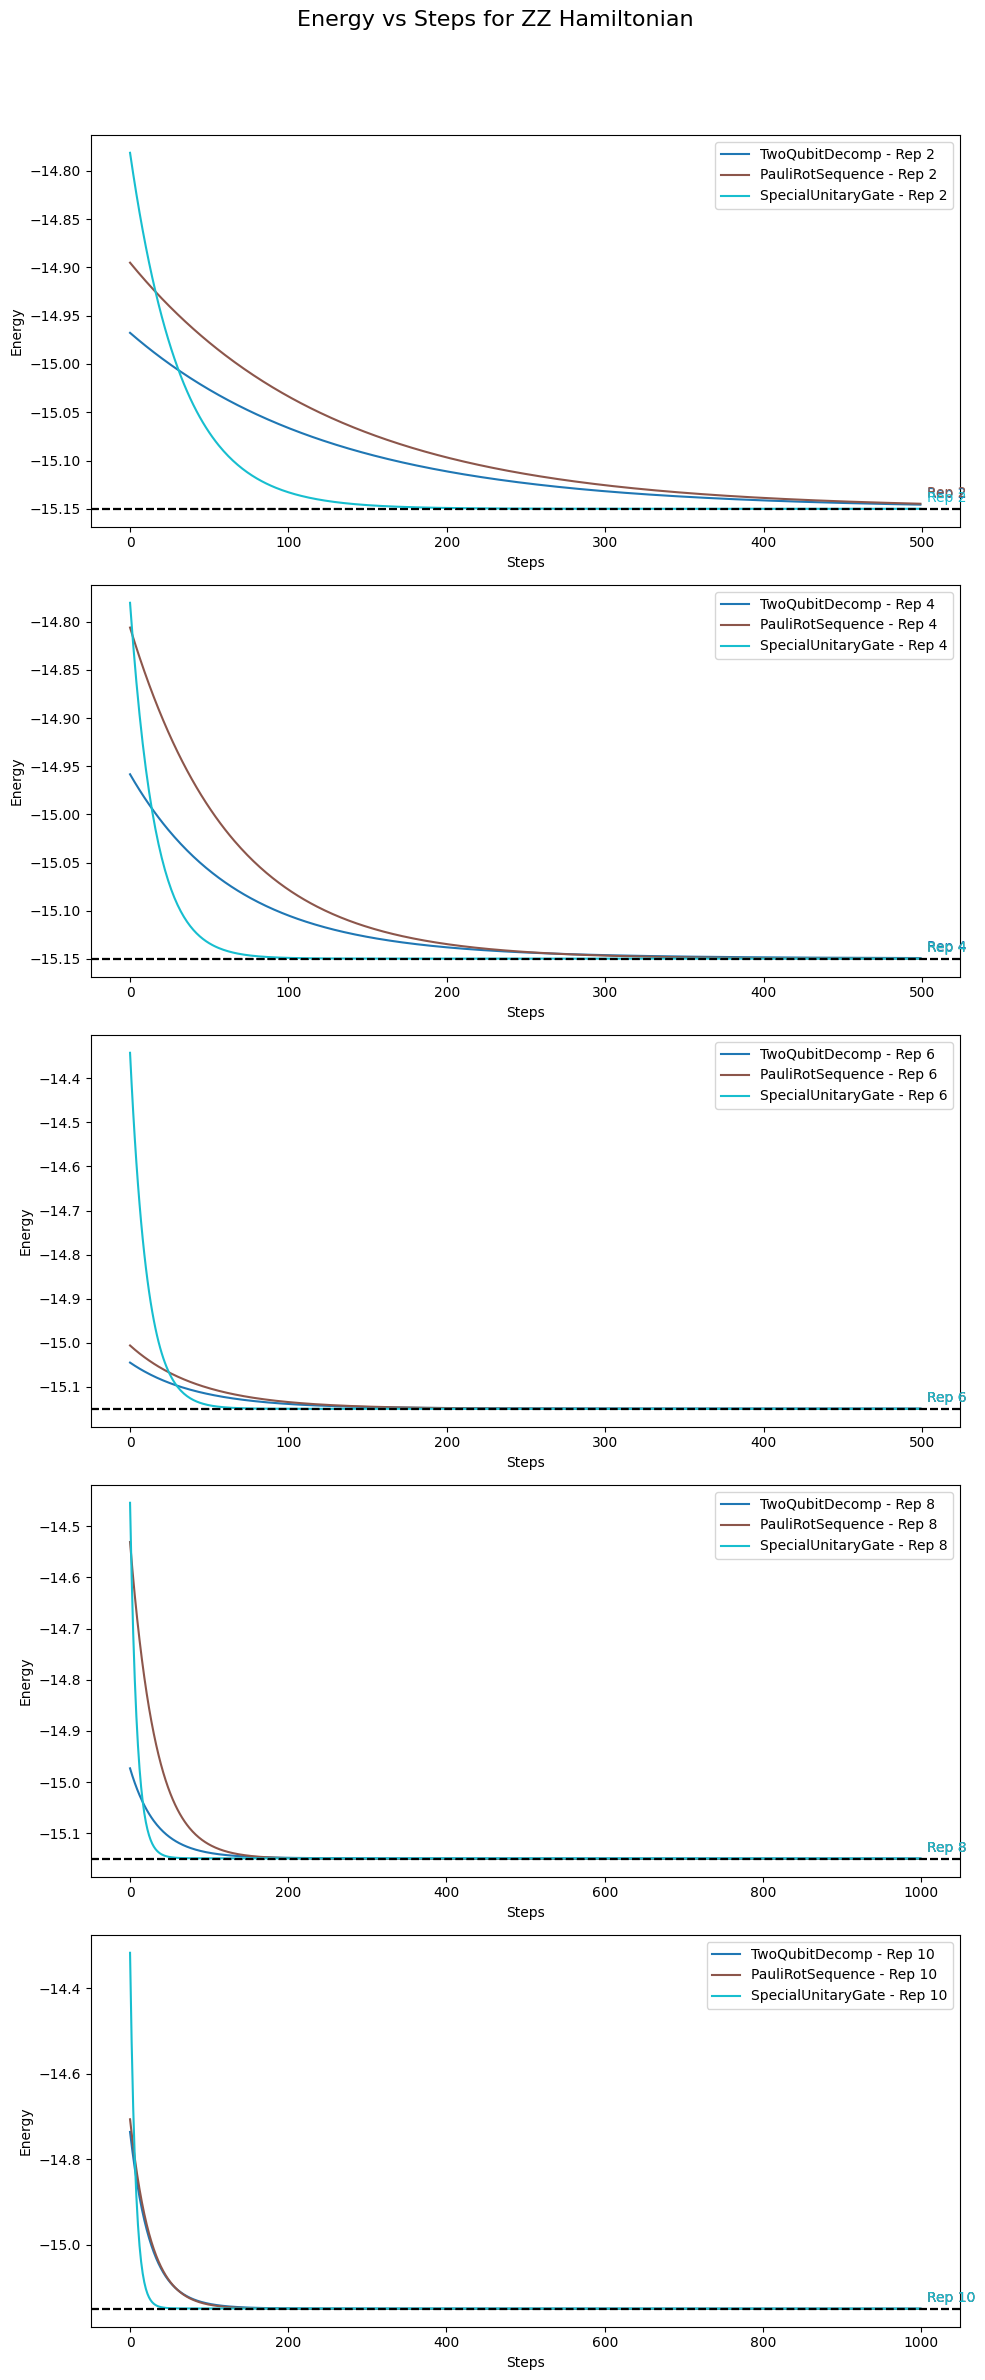

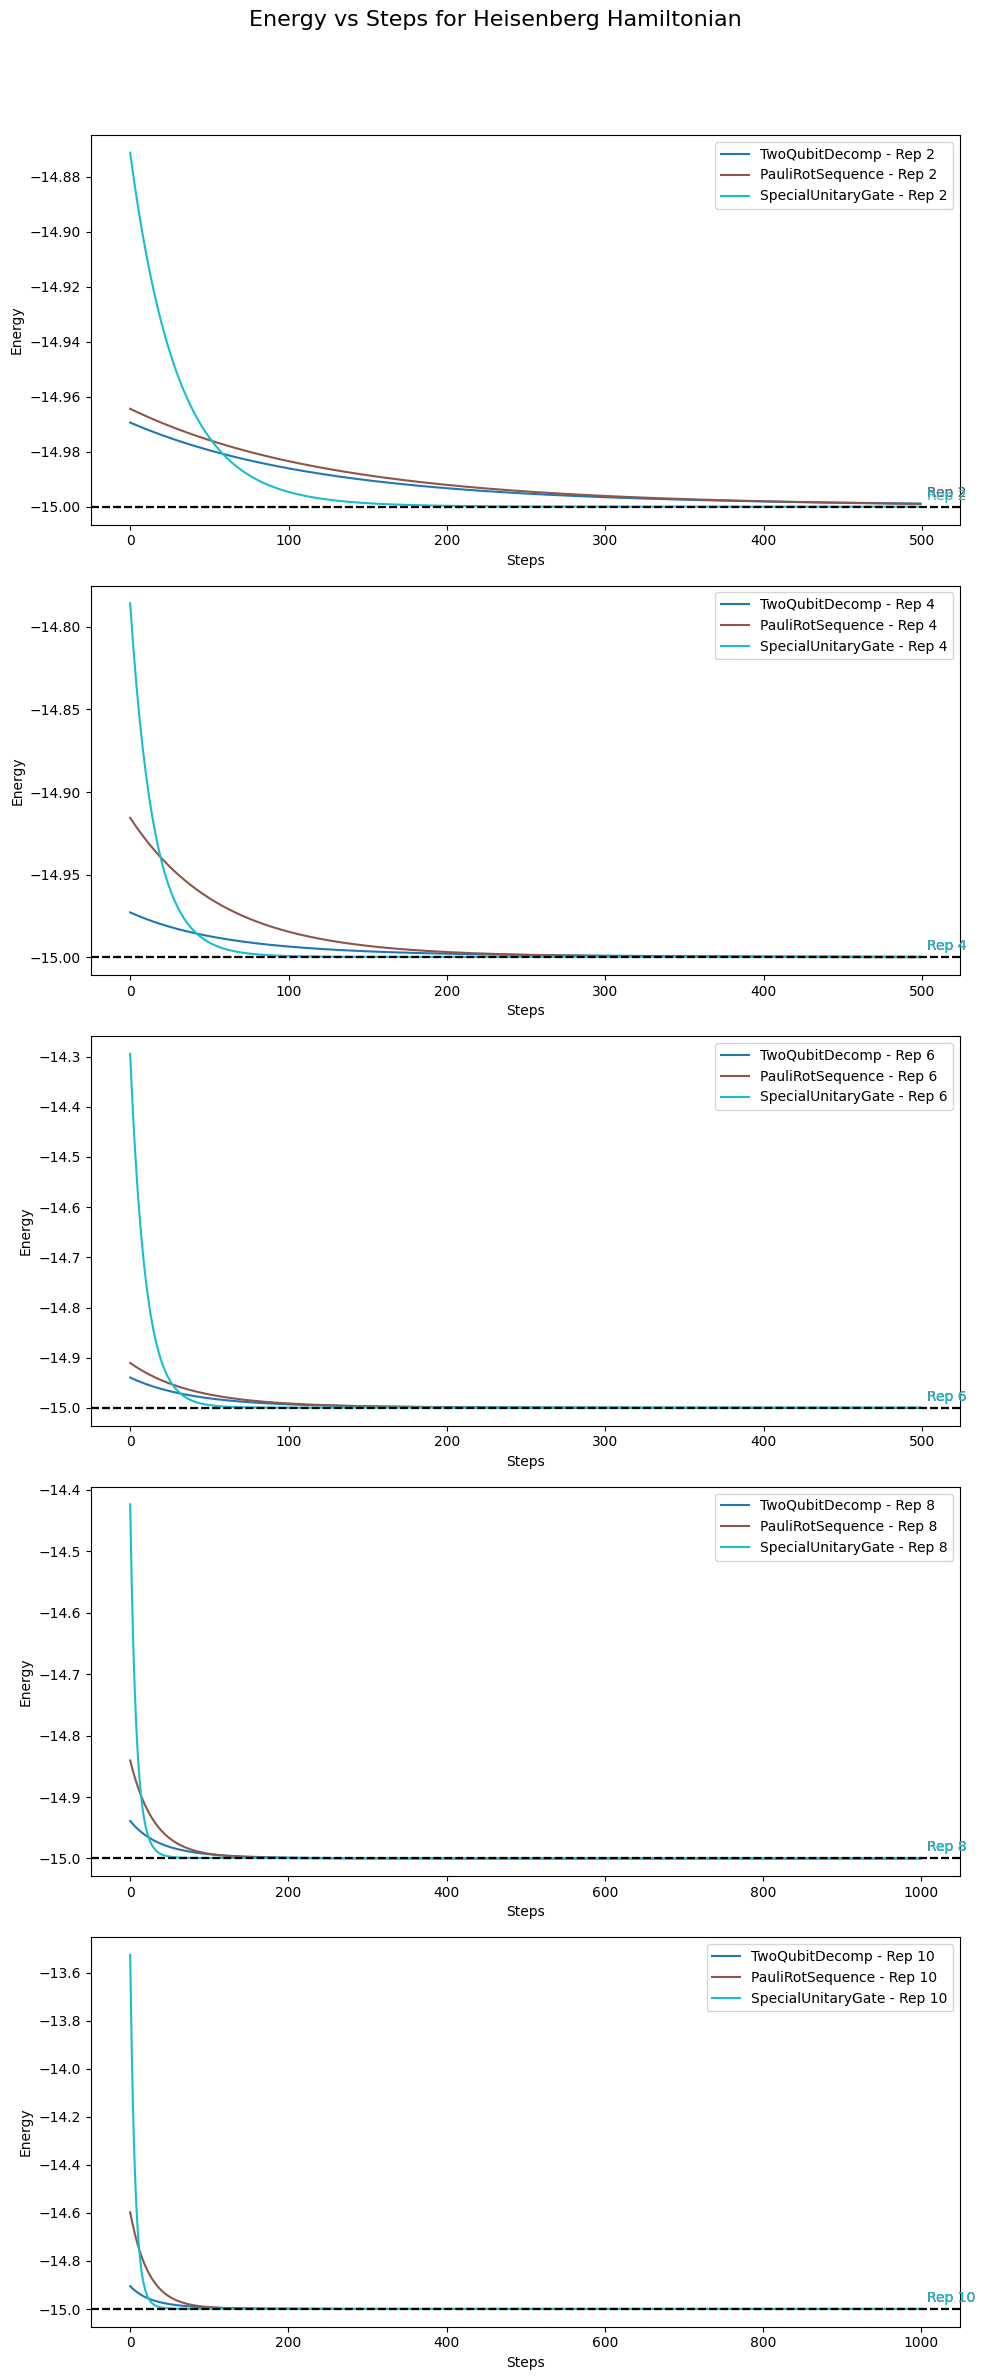

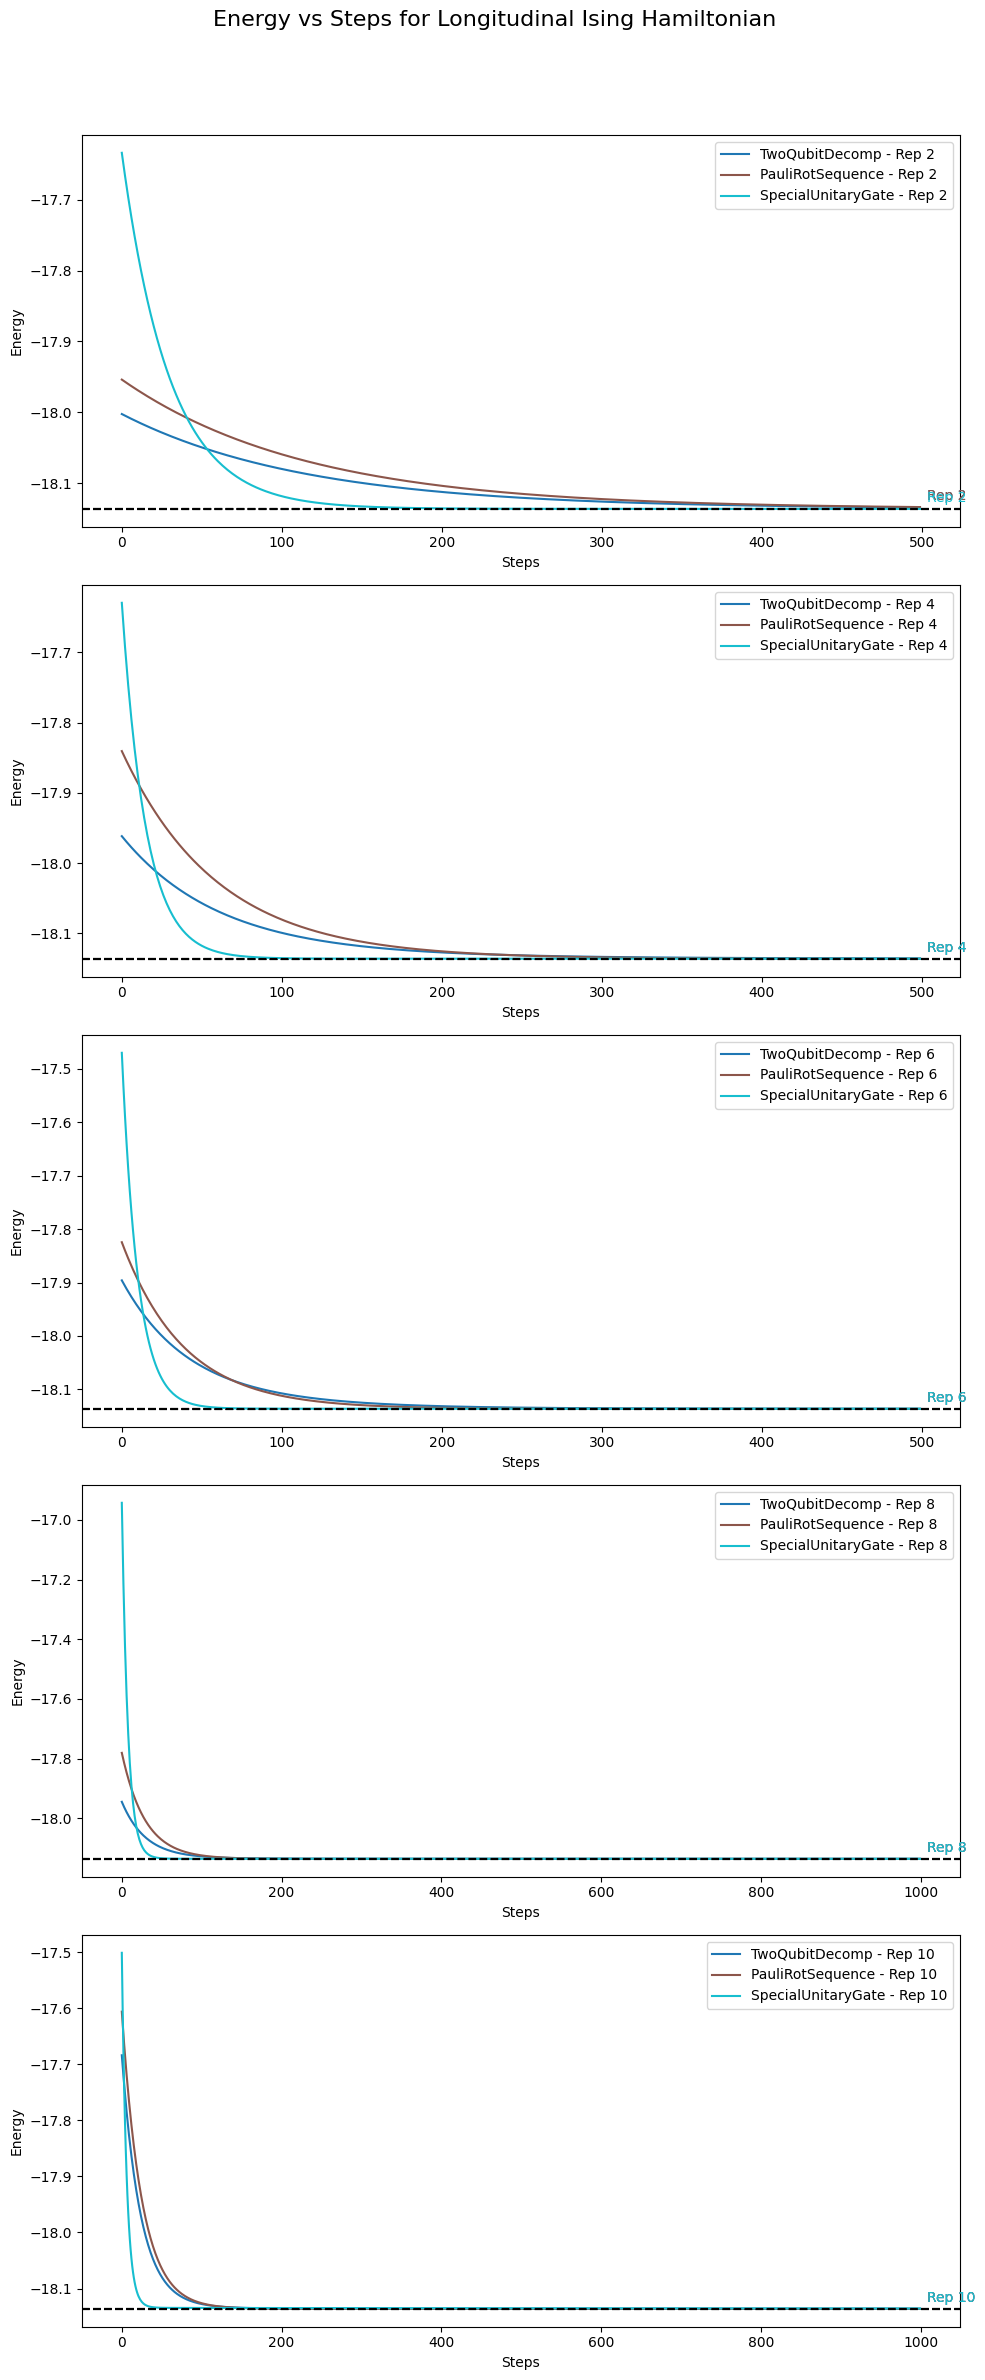

In [ ]:
def plot_energy_comparison(energies):
    for hamiltonian_name, operations in energies.items():
        num_reps = sorted(set(num_blocks for reps in operations.values() for num_blocks in reps.keys() if num_blocks % 2 == 0))
        
        fig, axs = plt.subplots(len(num_reps), 1, figsize=(10, 5 * len(num_reps)), squeeze=False)
        fig.suptitle(f"Energy vs Steps for {hamiltonian_name}", fontsize=16)
        
        colors = plt.cm.get_cmap('tab10', len(operations))  # Unique colors for each operation

        for rep_idx, rep in enumerate(num_reps):
            ax = axs[rep_idx, 0]
            for i, (operation_name, repetitions) in enumerate(operations.items()):
                if rep in repetitions:
                    values = repetitions[rep]
                    steps = list(range(len(values[0])))  # Steps are the index of the energy values
                    energy = values[0]
                    E_min = values[2]
                    ax.plot(steps, energy, label=f"{operation_name} - Rep {rep}", color=colors(i))
                    ax.annotate(f"Rep {rep}", xy=(steps[-1], energy[-1]), xytext=(5, 5),
                                textcoords='offset points', color=colors(i))
                    ax.axhline(y=E_min, color='black', linestyle='--')

            ax.set_xlabel("Steps")
            ax.set_ylabel("Energy")
            ax.legend()
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_energy_comparison(energies)

/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_8329/1702097190.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(operations))  # Unique colors for each operation


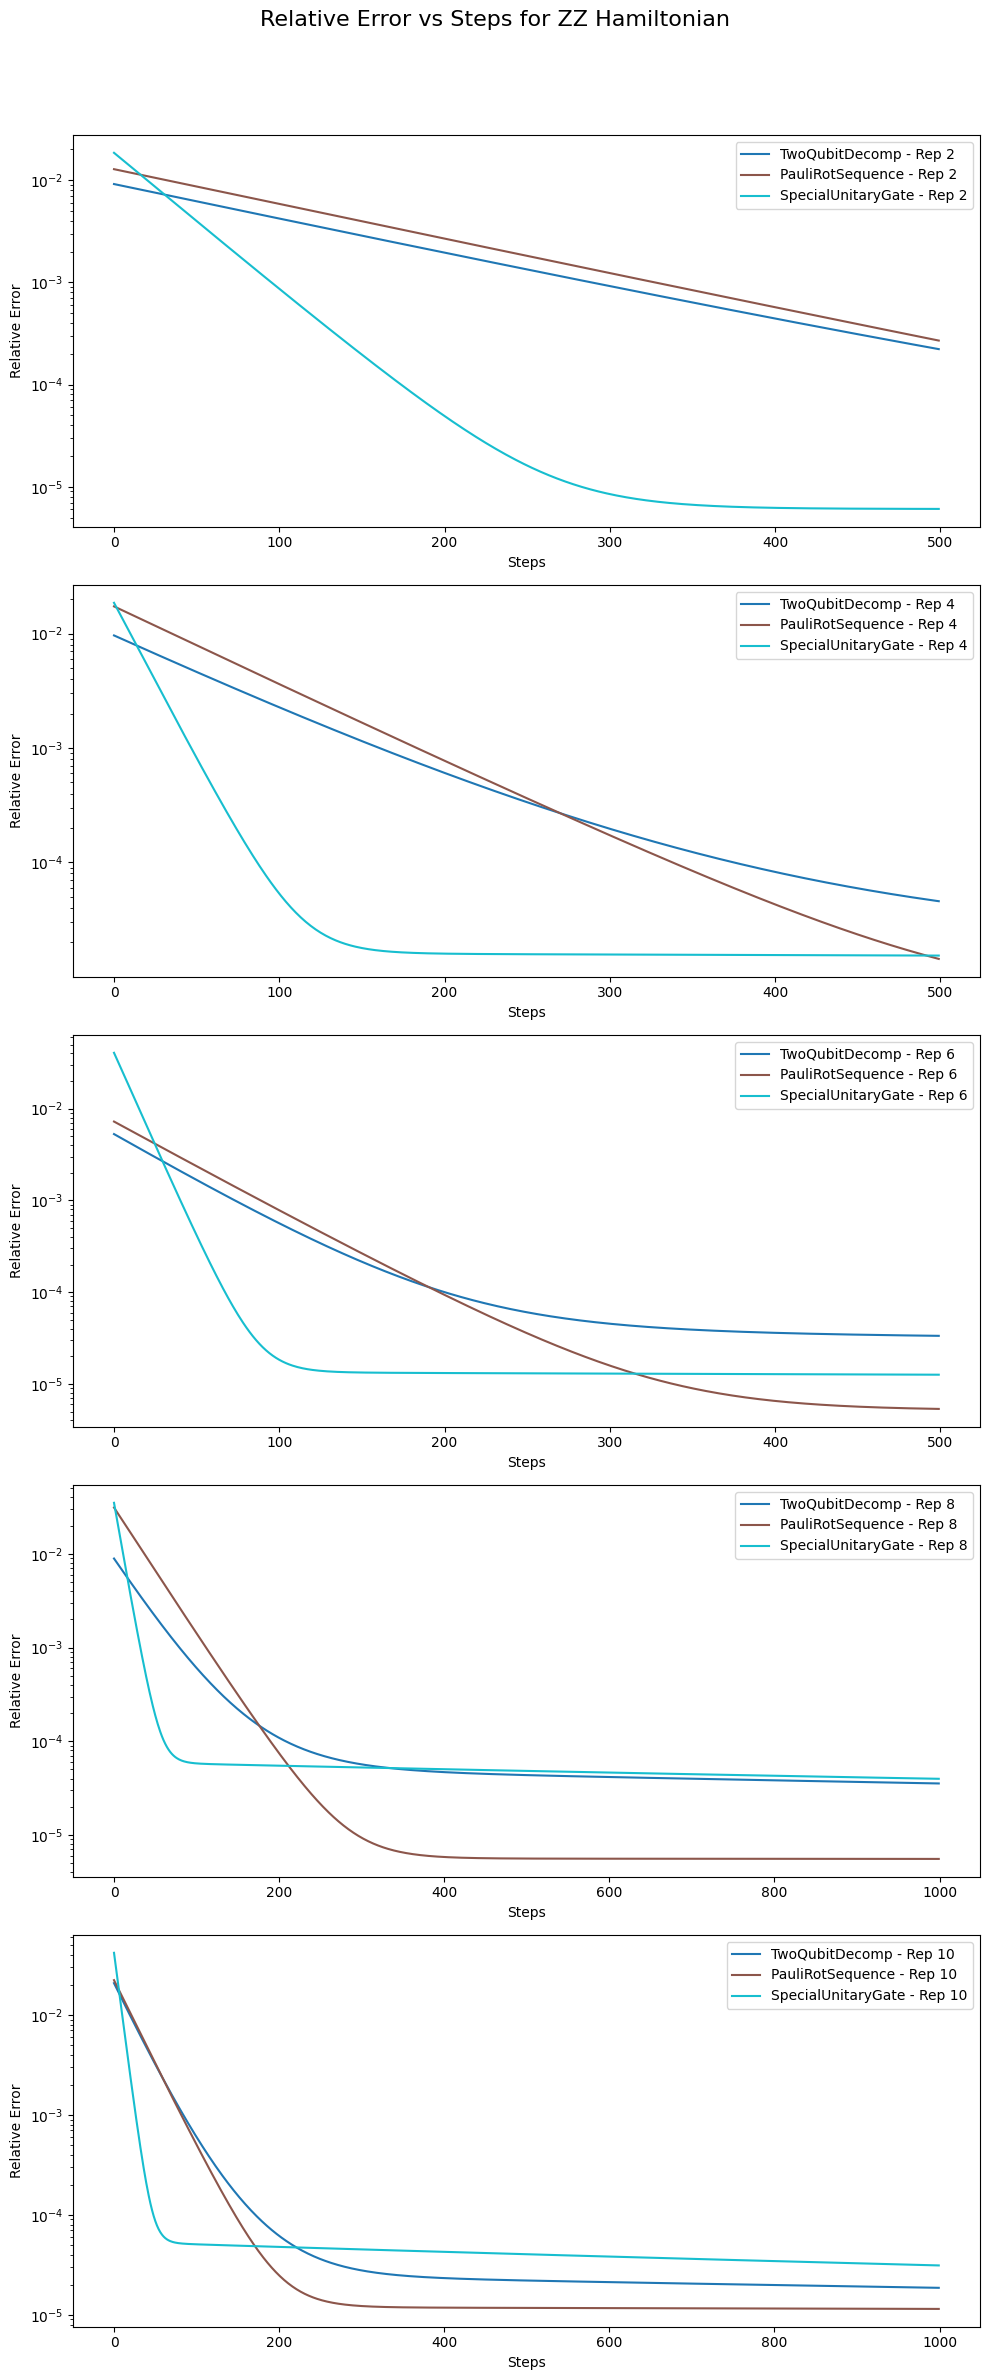

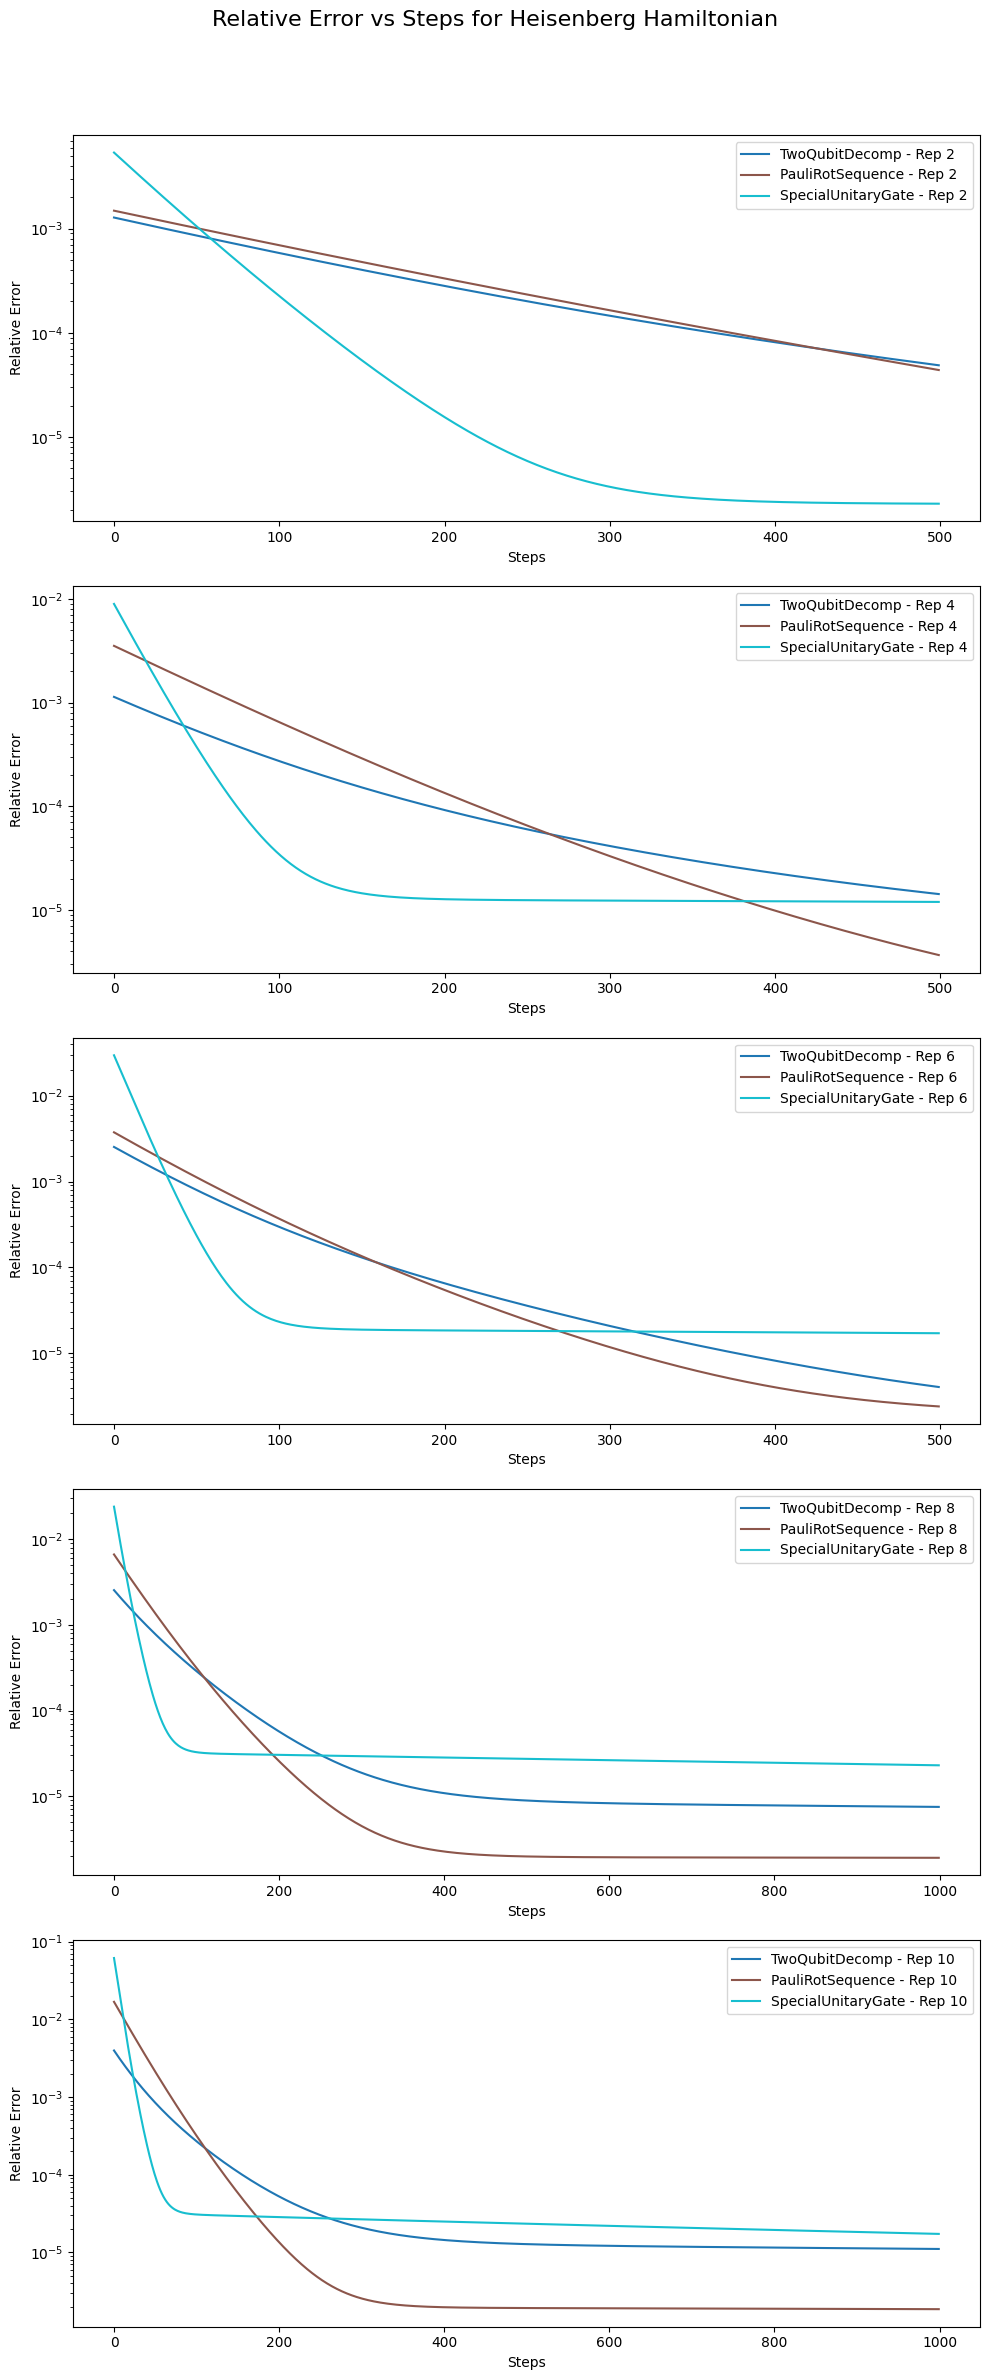

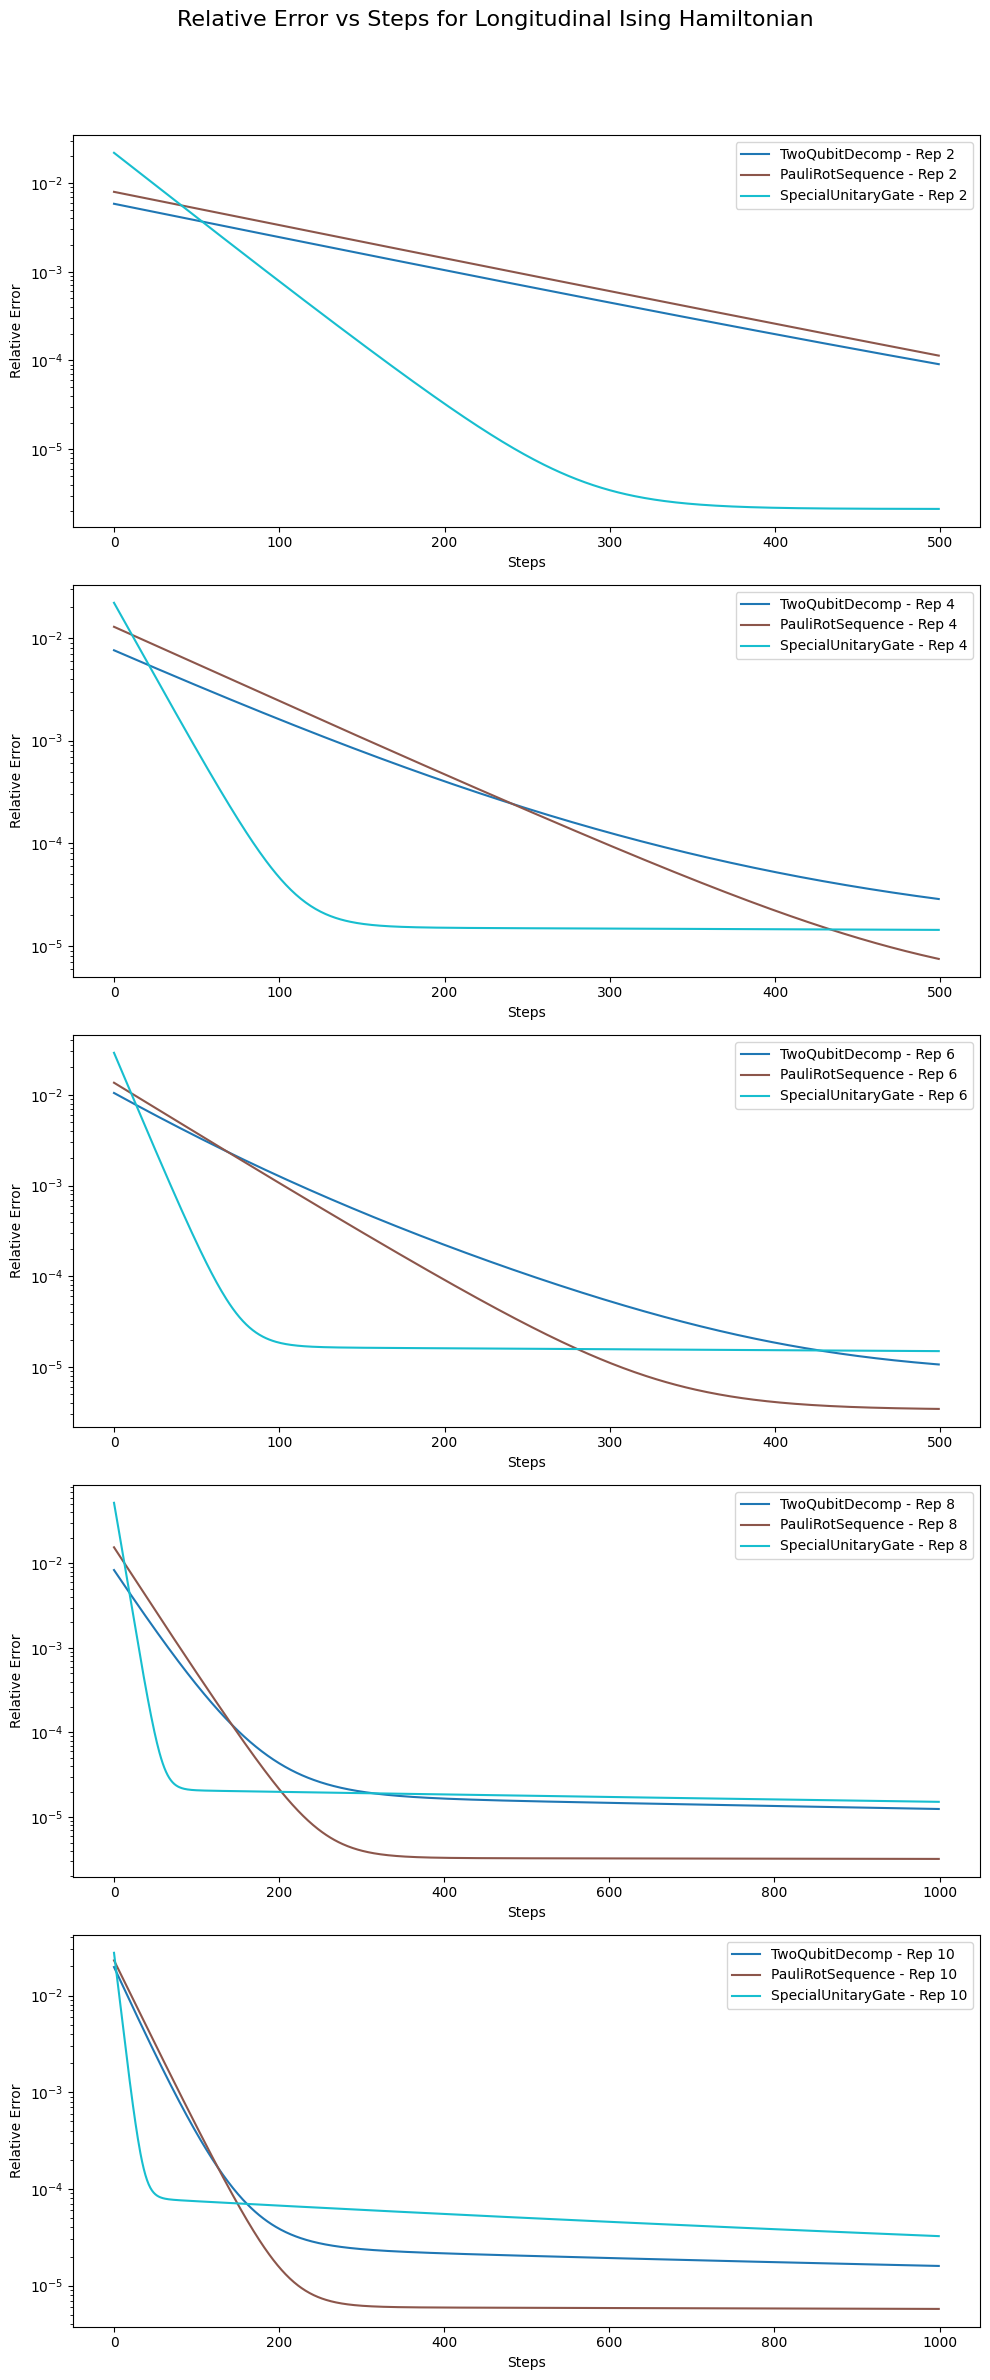

In [ ]:
def plot_energy_comparison(energies):
    for hamiltonian_name, operations in energies.items():
        num_reps = sorted(set(num_blocks for reps in operations.values() for num_blocks in reps.keys() if num_blocks % 2 == 0))
        
        fig, axs = plt.subplots(len(num_reps), 1, figsize=(10, 5 * len(num_reps)), squeeze=False)
        fig.suptitle(f"Relative Error vs Steps for {hamiltonian_name}", fontsize=16)
        
        colors = plt.cm.get_cmap('tab10', len(operations))  # Unique colors for each operation

        for rep_idx, rep in enumerate(num_reps):
            ax = axs[rep_idx, 0]
            for i, (operation_name, repetitions) in enumerate(operations.items()):
                if rep in repetitions:
                    values = repetitions[rep]
                    steps = list(range(len(values[0])))  # Steps are the index of the energy values
                    energy = values[0]
                    E_min = values[2]
                    E_max = values[3]
                    relative_error = (energy - E_min) / (E_max - E_min)
                    ax.plot(steps, relative_error, label=f"{operation_name} - Rep {rep}", color=colors(i))
            ax.set_yscale("log")
            ax.set_xlabel("Steps")
            ax.set_ylabel("Relative Error")
            ax.legend()
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_energy_comparison(energies)

In [ ]:
qnode, E_min, E_max = launch_circuit(lambda: create_transverse_hamiltonian(num_wires))
init_params = [-0.40972921,  1.67903213,  0.61485816, -0.75291112, -2.0291335,  -0.38710219,
  1.66529088, -0.48197564,  0.65580843, -1.60228828,  0.84226973, -0.56394601,
 -0.35333345,  1.69484409, -0.61487701]
cost1 = qnode(init_params, SpecialUnitaryGate())

init_params = [-0.40972921,  1.67903213,  0.61485816, -0.75291112, -2.0291335,  -0.38710219,
  1.66529088, -0.48197564,  0.65580843, -1.60228828,  0.84226973, -0.56394601,
 -0.35333345,  1.69484409, -0.61487701]
cost2 = qnode(init_params, TwoQubitDecomp())


NameError: name 'launch_circuit' is not defined